## A/B Testing on Landing Page Design (The Bayesian Approach)
**Author:** `'Bode Oyeneye.`

#### Preamble
The notebook is a demonstration of the usage of Bayesian Approach to ascertain the probability that one version of a landing page outperform another one, based on conversion rates. Normally, the pre-existing landing page is the one designated as Version A, while the new one is termed Version B. 

#### Objective
The primary objective is to determine if the new landing page design (Version B) is likely to increase conversion rates compared to the pre-existing one (Version A). Note, the design features and implementation for such landing page design is outside of the scope of the project.

##### General Assumptions
* Conversion is measured as either positive or negative, hence it's modeled as bernoulli trials for the synthetic examples
* The Bayesian model assumes Bernoulli likelihood and that the samples are independent and identically distributed (IID)

#### 0. Import relevant libraries

In [1]:
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import scipy.stats as stats

#### 1. Synthesis Data Generation

In [2]:
np.random.seed(42)

# Assume true conversion rates
true_conversion_rate_a = 0.10
true_conversion_rate_b = 0.12

# Number of page visitor per version
num_visitors_a = num_visitors_b = 1000

In [3]:
# Generate conversion data (Bernoulli trials)
conversions_a = np.random.binomial(1, true_conversion_rate_a, num_visitors_a)
conversions_b = np.random.binomial(1, true_conversion_rate_b, num_visitors_b)

observed_conversions_a = np.sum(conversions_a)
observed_conversions_b = np.sum(conversions_b)

total_trials_a = total_trials_b = num_visitors_b

In [4]:
print(f"Version A: Conversions = {observed_conversions_a}, Trials = {total_trials_a}")
print(f"Version B: Conversions = {observed_conversions_b}, Trials = {total_trials_b}")

Version A: Conversions = 100, Trials = 1000
Version B: Conversions = 112, Trials = 1000


#### 2. Prior Selection

Given that Beta distribution is the conjugate pair of bernoulli distribution, I will opt for it.
Ideally I would normally determine the alpha and beta for the beta distribution using historical data from the pre-existing landing page design for the same period as the experiment duration. For instance, if the experiment was run for a 3-month period, then I would take historical data from the preceding three months before the start of the exp., and then use the formulas below to determine the beta and alpha values for the conjugate prior (Beta distribution):

$$ \mu = \frac{\alpha}{\alpha + \beta} \tag{1} $$
$$ \sigma^2 = \frac{\alpha \cdot  \beta}{(\alpha + \beta)^2 \cdot (\alpha + \beta + 1)} \tag{2} $$ 

From the above two equations, we can then express the sum of beta and alpha as follows:
$$ \alpha + \beta = \frac{\mu \cdot (1-\mu)}{\sigma^2} - 1 \tag{3} $$

Using equations (1) and (3), one can the estimate the alpha and beta values. However, since the data is synthetic (with no historical data or information), I will use an uninformative prior: Beta(1, 1)

In [5]:
alpha_prior = beta_prior = 1

#### 3. Likelihood Function

As earlier assumption, this is based on Bernoulli distribution, since a visitor to the landing page either converts or not

#### 4. Posterior Inference 

Here, I am using the PyMC package: A Bayesian statistical modeling focusing on advanced Markov chain Monte Carlo (MCMC) and variational inference (VI) algorithms (see its [pypi link](https://pypi.org/project/pymc/))

In [6]:
with pm.Model() as model:
    # Priors
    conversion_rate_a = pm.Beta("conversion_rate_a", alpha=alpha_prior, beta=beta_prior)
    conversion_rate_b = pm.Beta("conversion_rate_b", alpha=alpha_prior, beta=beta_prior)

    # Likelihood
    likelihood_a = pm.Binomial(
        "likelihood_a", n=total_trials_a, p=conversion_rate_a, observed=observed_conversions_a
    )
    likelihood_b = pm.Binomial(
        "likelihood_b", n=total_trials_b, p=conversion_rate_b, observed=observed_conversions_b
    )

    delta = pm.Deterministic("delta", conversion_rate_b - conversion_rate_a)

    # Sample from the posterior
    # draws = number of MCMC samples
    # tune = number of burn-in samples (discarded)
    # cores = number of chains running in parallel.  Setting cores=1 can sometimes help with debugging.  More chains are generally better for assessing convergence.
    trace = pm.sample(draws=2000, tune=1000, cores=4)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [conversion_rate_a, conversion_rate_b]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.


#### 5. Results

In [7]:
# Summary of posterior distribution
summary = az.summary(trace, var_names=["conversion_rate_a", "conversion_rate_b", "delta"])
print(summary)

                    mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
conversion_rate_a  0.101  0.009   0.082    0.118        0.0      0.0   
conversion_rate_b  0.113  0.010   0.094    0.131        0.0      0.0   
delta              0.012  0.014  -0.014    0.038        0.0      0.0   

                   ess_bulk  ess_tail  r_hat  
conversion_rate_a    7993.0    5284.0    1.0  
conversion_rate_b    7856.0    5930.0    1.0  
delta                8062.0    5769.0    1.0  


In [8]:
# Calculate the probability that Version B is better than Version A
posterior_samples = trace.posterior["delta"].values.flatten() # flatten for easier calculations
probability_b_better_than_a = np.mean(posterior_samples > 0)

print(f"\nProbability that Ver. B is better than Ver. A: {probability_b_better_than_a:.4f}")


Probability that Ver. B is better than Ver. A: 0.8174


In [9]:
# Make a Business Recommendation

def make_biz_recommendation(prob: float, threshold: float = 0.95) -> str:
    """
    Make business recommendation based on the probability
    that version B is better than version A based on a pre-
    defined threshold

    :param prob: the probability that B is better than A

    :Return
        `str` - Actionable decision
    """
    if prob > threshold:
        print(
            "Recommendation: Deploy the new version B\n" +
            "There is a strong evidence of improvement"
        )
    elif prob < 1 - threshold:
        print(
            "Recommendation: Do not deploy the new version B\n" +
            "There is a strong evidence of deterioration"
        )
    else:
        print(
            "Recommendation: Further testing is needed\n" +
            "The evidence is not conclusive enough to recommend deploying the new version"
        )

In [10]:
make_biz_recommendation(probability_b_better_than_a)

Recommendation: Further testing is needed
The evidence is not conclusive enough to recommend deploying the new version


#### 6. Visualization

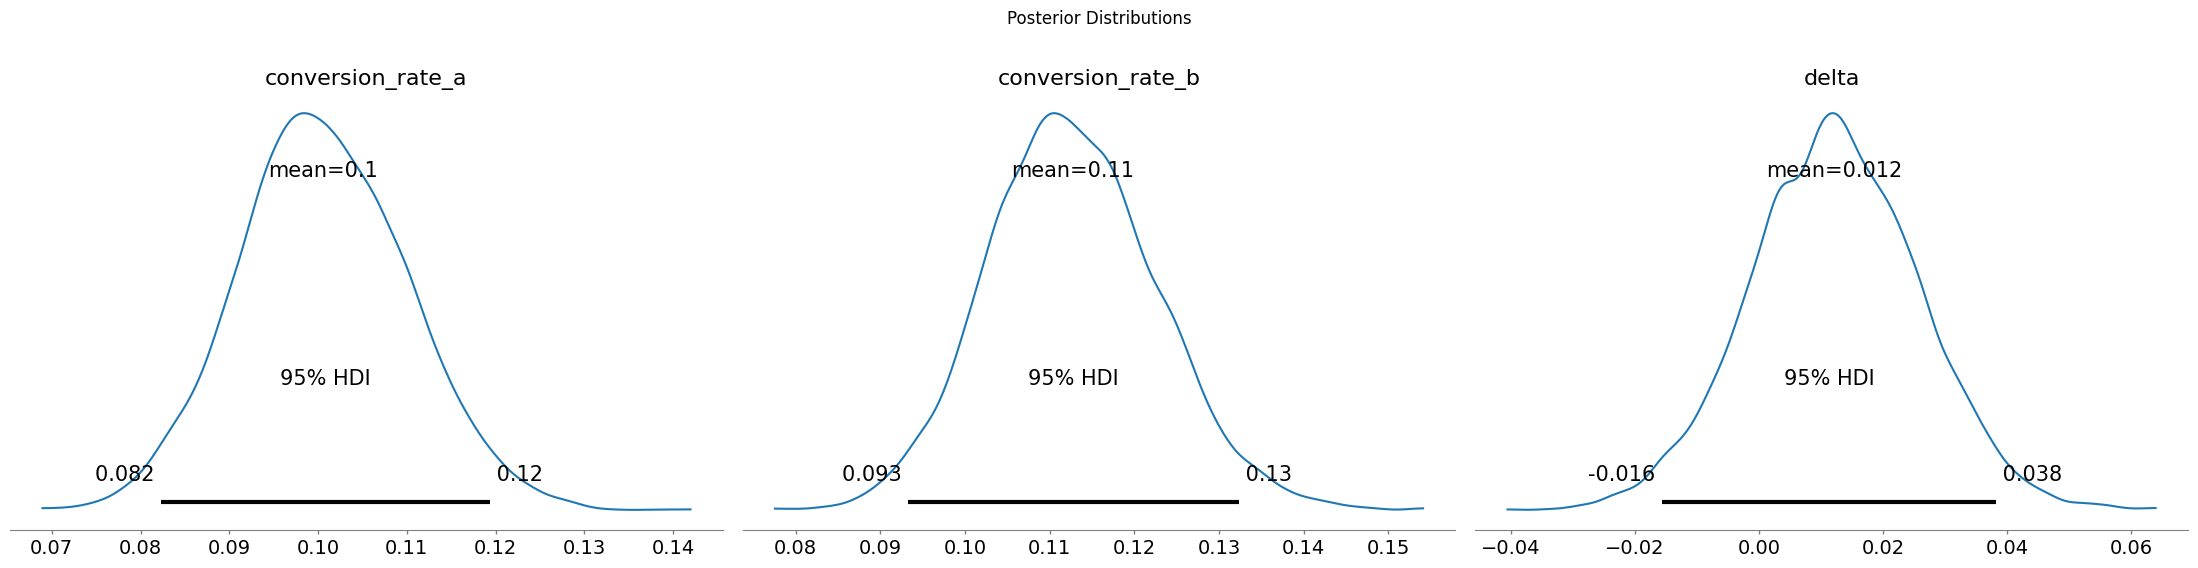

In [11]:
az.plot_posterior(trace, var_names=["conversion_rate_a", "conversion_rate_b", "delta"], hdi_prob=0.95)
plt.suptitle("Posterior Distributions", y=1.02)
plt.tight_layout()
plt.show()

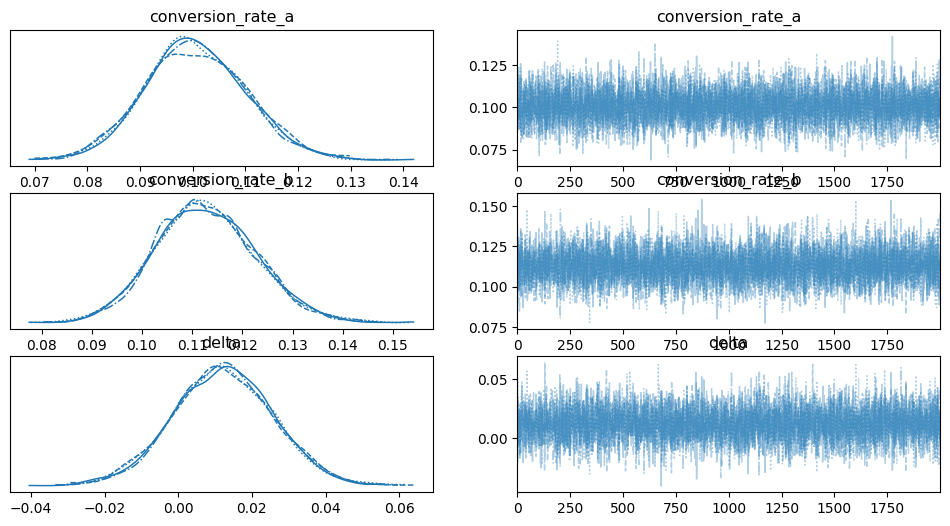

In [12]:
# Visualize the trace plots to check for convergence
az.plot_trace(trace, var_names=["conversion_rate_a", "conversion_rate_b", "delta"])
plt.show()

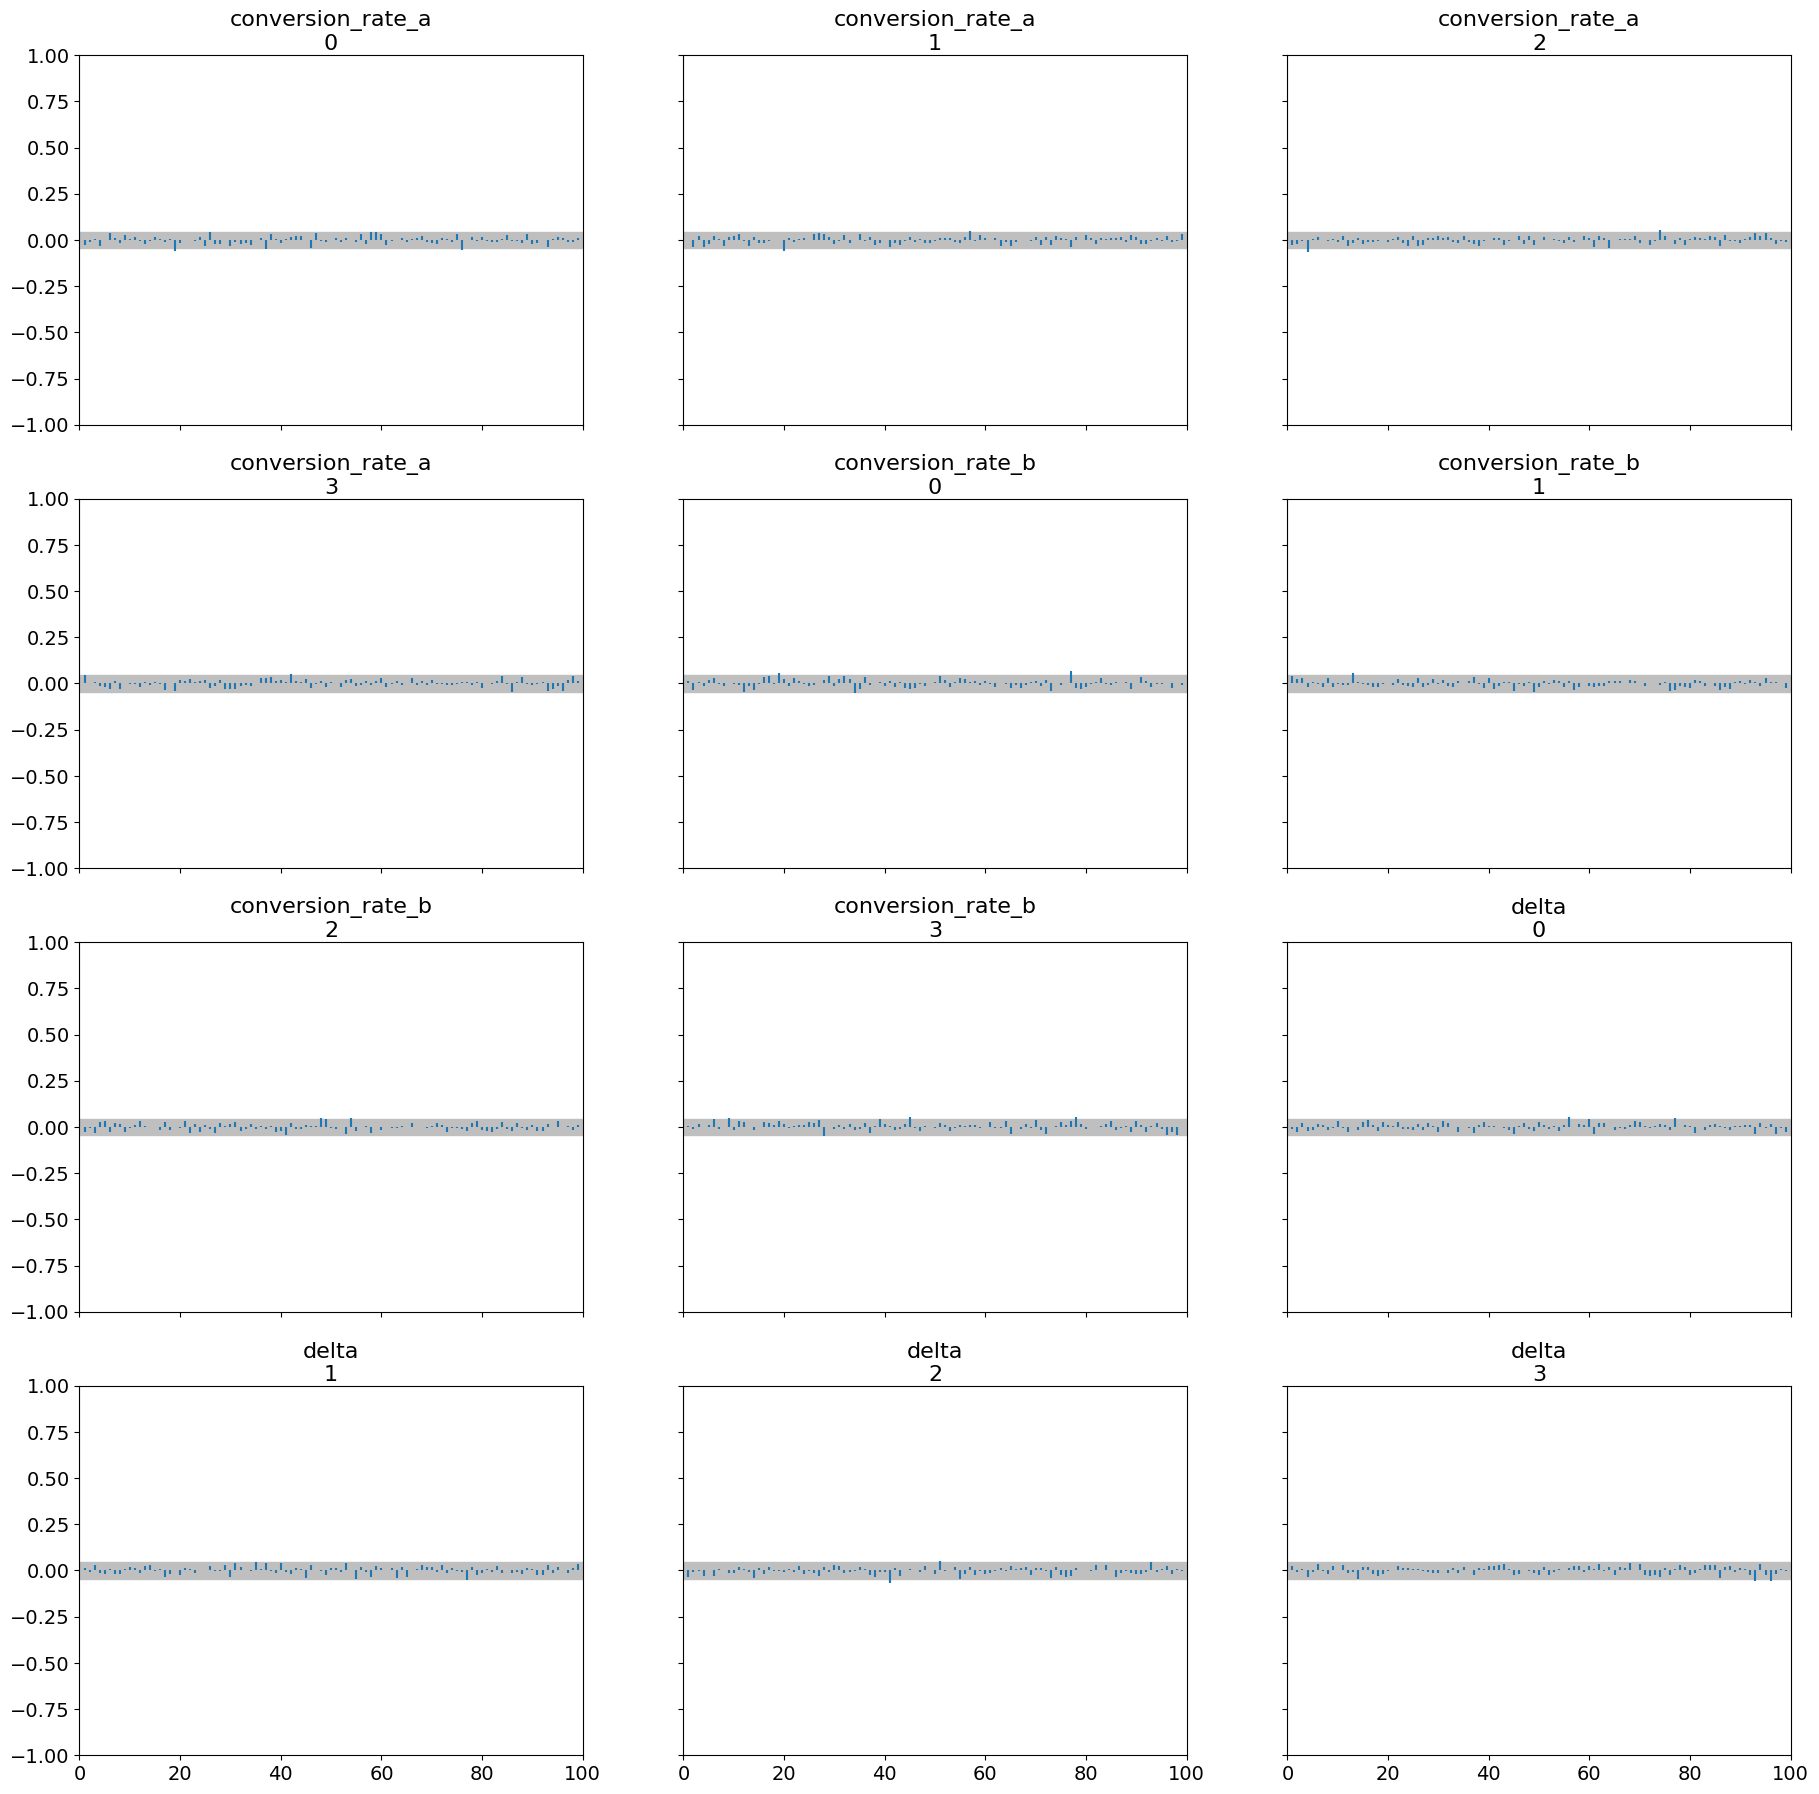

In [13]:
# Autocorrelation Plot
az.plot_autocorr(trace, var_names=["conversion_rate_a", "conversion_rate_b", "delta"])
plt.show()

The autocorrelation plots have values ranging between -0.05 and +0.05 designifying that there is very little correlation between successive samples in the MCMC chains, because of good mixing by the sampler which explorer the parameter space efficiently, thereby generating sample that are essentially independent.

#### 7. Conclusion and recommendations

As seen from the results, there exists no conclusive evidence that version B outperformed version A. However it should be noted that this is just a demonstration, in cases that doesn't over simplified real-world scenarios, considerations will be given to external factors that might be deemed to impact conversion rates (e.g. seasonality, marketing campaigns and the likes). More so, a more informative prior based on historical data or domain expert knowledge would be beneficial, along with the incorporation of covariates (e.g., user demographics, traffic source) to leverage Bayesian hierarchical models.

**Other recommendation**: Multi-armed bandit algorithms allows for adaptive A/B testing, since it automatically allocates more traffic to the better-performing version.